<a href="https://colab.research.google.com/github/zhukuixi/work/blob/main/Cox_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  6 12:31:41 2023

@author: Kuixi Zhu
"""

import pandas as pd

gene_53 = pd.read_csv("/content/work/1106_CoxModel/53GenePanel/53gene.csv")
gene_53.FinalGeneName.replace({'HLA.DPA1':'HLA-DPA1','HLA.DPB1':'HLA-DPB1','HLA.DQB1':'HLA-DQB1'},inplace=True)
feature = list(gene_53.iloc[:,0]) + ['Survival','event_occurred']
feature_gene = list(gene_53.iloc[:,0])


# sinai
data_sinai = pd.read_csv("/content/work/1106_CoxModel/NormalizedData/SinaiData/TrainingDataFinal.csv")
data_sinai.set_index('SampleIndex',inplace=True)
survival_sinai = pd.read_csv("/content/work/1106_CoxModel/NormalizedData/SinaiData/SINAIDISCOVERYFORRUI2023_Clinic.csv",skiprows=[1,2],nrows=44)
survival_sinai = survival_sinai.loc[:,['RCC Name','Survival','Died Melanoma']]
survival_sinai['Died Melanoma'].replace({'unk':0},inplace=True)
survival_sinai.rename({'Died Melanoma':'event_occurred'},axis=1,inplace=True)
data_sinai = data_sinai.reset_index()
data_sinai = data_sinai.merge(survival_sinai,left_on='SampleIndex',right_on = 'RCC Name')
data_sinai.set_index('SampleIndex',inplace=True)
data_sinai['event_occurred'] = data_sinai['event_occurred'].astype('int')


# columbia
data_columbia  = pd.read_csv("/content/work/1106_CoxModel/NormalizedData/ColumbiaData/Columbia.Normalized_ys_4HK.csv")
data_columbia = data_columbia.set_index('Unnamed: 0').T
data_columbia = data_columbia.reset_index()
data_columbia.rename({'index':'SampleIndex','CD180':'LY64','HLA-E':'HLAE','IL37':'IL1F7'},axis=1,inplace=True)
data_columbia.set_index('SampleIndex',inplace=True)

survival_columbia = pd.read_csv('/content/work/1106_CoxModel/NormalizedData/ColumbiaData/Merged_Normalized_covariate_Columbia.csv')
survival_columbia = survival_columbia.loc[:,['SampleID','Survival Months','Died of Melanoma (follow up>36 months)']]
survival_columbia['Died of Melanoma (follow up>36 months)'].replace({'unk':0},inplace=True)
survival_columbia.rename({'Survival Months':'Survival','Died of Melanoma (follow up>36 months)':'event_occurred'},axis=1,inplace=True)
data_columbia = data_columbia.reset_index()
data_columbia = data_columbia.merge(survival_columbia,left_on='SampleIndex',right_on = 'SampleID')
data_columbia.set_index('SampleIndex',inplace=True)
data_columbia['event_occurred'] = data_columbia['event_occurred'].astype('int')

# roswell
data_rosewell = pd.read_csv("/content/work/1106_CoxModel/NormalizedData/RoswellData/Roswell.Normalized_ys_4HK.csv")
data_rosewell = data_rosewell.set_index('Unnamed: 0').T
data_rosewell = data_rosewell.reset_index()
data_rosewell.rename({'index':'SampleIndex','CD180':'LY64','HLA-E':'HLAE','IL37':'IL1F7'},axis=1,inplace=True)
data_rosewell.set_index('SampleIndex',inplace=True)
data_rosewell = data_rosewell.loc[:,list(gene_53.iloc[:,0])]


# outlier

outlier = pd.read_csv('/content/work/1106_CoxModel/OutlierIDs.csv')
outlier_sample = outlier.iloc[:,1].to_list()

data_sinai= data_sinai.loc[:,feature]
data_columbia = data_columbia.loc[:,feature]
data_combo = pd.concat([data_sinai,data_columbia])
data_combo['event_occurred'] = data_combo.event_occurred.astype('int')


removed_sample = ["X.X20230503_1.1.31021038722_T20210528.1_01.RCC.",
  "X.X20230615_2.31020999446_s.mip53_01.RCC.",
  "X.X20230615_3.31020999447_s.mip53_01.RCC.",
  "X.X20230616_4.31020999448_s.mip53L2_01.RCC.",
  "X.X20230623_5.31020999449_MIP52L2_01.RCC.",
  "X.X20230623_6.31020999471_MIP52L2_01.RCC.",
  "X.X20230711_7.31021038724_T20210528.1_01.RCC.",
  "X.X20230711_8.31021038725_T20210528.1_01.RCC.",
  "X.X20230712_10.31021038677_T20210528.1_01.RCC.",
  "X.X20230712_9.31021038676_T20210528.1_01.RCC.",
  "X.X20230713_11_T20210528.1_01.RCC.",
  "X.X20230713_12.31021038629_T20210528.1_01.RCC.",
  "X.X20230714_13.31021038627_T20210528.1_01.RCC.",
  "X.X20230714_14.31021038700_T20210528.1_01.RCC.",
   "X.X20230615_3.31020999447_9_05.RCC.",

  "X.X20230616_4.31020999448_41b_10.RCC.",

  "X.X20230711_8.31021038725_18C_08.RCC.",

  "X.X20230714_14.31021038700_49d_10.RCC."]



removed_sample = [sample[2:-5].replace('.','-')+".RCC" for sample in removed_sample]
# remove samples
data_rosewell = data_rosewell.loc[~data_rosewell.index.isin(removed_sample),]



In [65]:
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [66]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

<Axes: xlabel='timeline'>

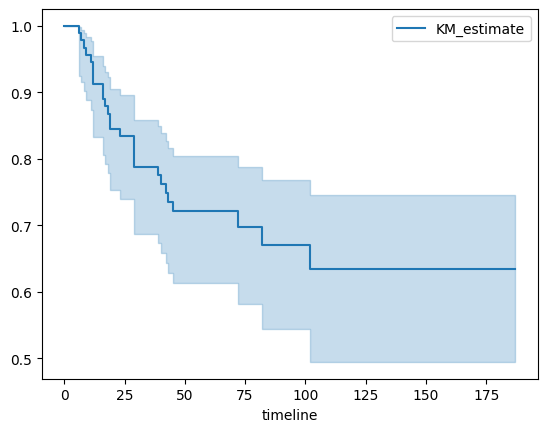

In [67]:
T = data_combo['Survival']
E = data_combo['event_occurred']
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

Text(0.5, 1.0, 'Survival of different cohort')

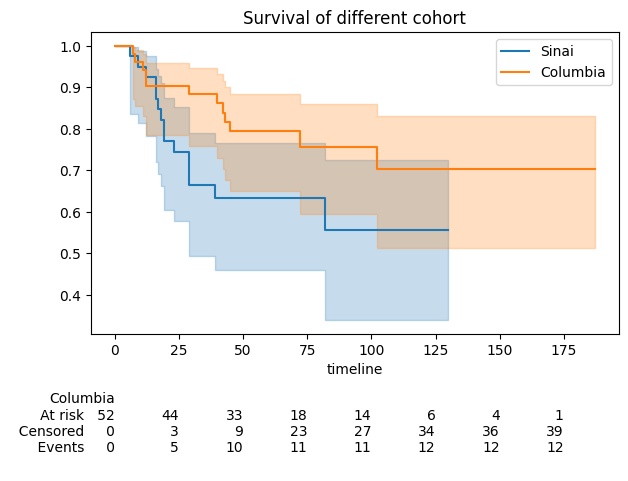

In [68]:
ax = plt.subplot(111)
m = data_combo.index.str.contains('Sinai')
kmf.fit(durations = T[m], event_observed = E[m], label = "Sinai")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "Columbia")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different cohort")

In [97]:
cph = CoxPHFitter()
cph.fit(data_combo, duration_col = 'Survival', event_col = 'event_occurred')
cph.print_summary()
#cph.check_assumptions(data_combo, p_value_threshold = 0.05)
y = cph.predict_expectation(data_rosewell)
y.to_csv("/rosewell_train_92.csv")

<lifelines.CoxPHFitter: fitted with 92 total observations, 65 right-censored observations>
             duration col = 'Survival'
                event col = 'event_occurred'
      baseline estimation = breslow
   number of observations = 92
number of events observed = 27
   partial log-likelihood = -102.90
         time fit was run = 2023-11-07 01:24:34 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD2        -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
KLRK1      -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
HLAE       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IFNAR1      0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ITK        -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
CD4        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
LCK        -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.05
LGMN       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IFI27      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CCR4        0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
CTSS        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD68        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IRF5        0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
LY64        0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
TAP2       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
TAP1        0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
CSF2RA     -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
IFITM1      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CXCR3      -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
TNFSF13B   -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
IRF2       -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
HLA-DQB1    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IKZF1       0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
CD53        0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
IRF9        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ITGAL       0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
STAT1      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CCL27       0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ICOS       -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
CD48        0.00       1.00       0.01            -0.02             0

In [ ]:
#cph.check_assumptions(data_combo, p_value_threshold = 0.05)

In [98]:
cph = CoxPHFitter()
cph.fit(data_combo.loc[~data_combo.index.isin(outlier_sample),:], duration_col = 'Survival', event_col = 'event_occurred')
cph.print_summary()
#cph.check_assumptions(data_combo, p_value_threshold = 0.05)
y = cph.predict_expectation(data_rosewell)
y.to_csv("/rosewell_train_90.csv")


<lifelines.CoxPHFitter: fitted with 90 total observations, 63 right-censored observations>
             duration col = 'Survival'
                event col = 'event_occurred'
      baseline estimation = breslow
   number of observations = 90
number of events observed = 27
   partial log-likelihood = -102.54
         time fit was run = 2023-11-07 01:24:40 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CD2        -0.01       0.99       0.03            -0.07             0.06                 0.93                 1.06
KLRK1      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
HLAE       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IFNAR1      0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ITK        -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
CD4         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
LCK        -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
LGMN        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IFI27      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CCR4        0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
CTSS        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD68       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IRF5        0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
LY64        0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
TAP2       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
TAP1        0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
CSF2RA     -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
IFITM1      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CXCR3      -0.01       0.99       0.03            -0.07             0.06                 0.94                 1.06
TNFSF13B   -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
IRF2       -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
HLA-DQB1    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IKZF1       0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
CD53        0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
IRF9        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ITGAL       0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
STAT1      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CCL27       0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
ICOS       -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
CD48        0.00       1.00       0.01            -0.02             0